# UGC 9519 Calibration Tutorial

In this tutorial you will calibrate 20cm observations of UGC 9519. 

This tutorial includes 
* File Import.
* Cross calibration.
* Imaging. 
* Self calibration. 

The calibration is done using two important libraries: ``calibrate`` and ``lib``. 

``calibrate`` contains commonly used tools, task hooks and functions for calibration. 

``tools`` contains a basic library for low-level interaction with **``WSRTFITS``** tasks.

### Header Cell

The first cell is the header cell, and is hopefully a cell that *you will never have to touch*. This cell sets up all the necessary libraries and settings for your calibration. In this particular cell, the following operations are done:
* The ``lib`` module is imported.
* The logger is setup.
* Inline plotting is enabled, and a matplotlib plotting library is imported.
* The ``calibrate`` module is imported.
    * The ``crosscal`` object is is defined as ``ccal``.
    * The ``selfcal`` object is defined as ``scal``.
    
**This cell should never be re-run within a python session.** The logging and namespace variables will be screwed up, so if you really want to re-execute the cell, you need to restart the kernel.

In [1]:
# Header Cell. You should NOT rerun this block if you have not restarted the kernel.
from apercal import lib
lib.setup_logger('debug', logfile='/home/frank/ugc9519-tutorial.log')
import pylab as pl
%matplotlib inline
from apercal import calibrate
ccal = calibrate.crosscal()
scal = calibrate.wselfcal()

root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/frank/ugc9519-tutorial.log


Setup logger with lib.setup_logger()


### The ``source`` class

The ``calibrate`` library allows you to define useful source objects. These objects are containers, which once defined, carry useful information such as the path of the raw data and working directory, the names of the MS and UVFITS files and the output ``MIRIAD`` UV files that you intend on working with. 

In this example the ``path``, ``uvf`` and ``vis`` attributes are used, since the data resides in the path that we are working in. 
The ``update`` method defines a few more defaults, and should be executed after you add/edit values. 

The ``calibrate.source`` object also has a useful hook that prints the file history. More on this later. 

In [2]:
# First, we define the source for the primary calibrator
cal1 = calibrate.source()
path = '/home/frank/tutorials/tutorial-ugc9519'
cal1.path = path
cal1.uvf = '11104360_S0_T0.UVF'
cal1.vis = 'cal1.uv'
cal1.update()

# The secondary calibrator, which we will not use.
cal2 = calibrate.source()
cal2.path = path
cal2.uvf = '11104362_S0_T0.UVF'
cal2.vis = 'cal2.uv'
cal2.update()

# The first data file for the source
src1 = calibrate.source()
src1.path = path
src1.uvf = '11104361_S0_T0.UVF'
src1.vis = 'src1.uv'
src1.update()

# The second data file for the source
src2 = calibrate.source()
src2.path = path
src2.uvf = '11104361_S0_T1.UVF'
src2.vis = 'src2.uv'
src2.update()

# An object for the concatenated file
src = calibrate.source()
src.path = path
src.vis = 'src.uv'
src.update()

# An object for the continuum data set, which we will use for selfcal later.
s0 = calibrate.source()
s0.path = path
s0.vis = 'src.uv_chan0'
s0.update()


## File Import

The UVFITS file has been produced, so we have a fairly straightforward job to import the data:

``file.UVF`` $\rightarrow$ **``WSRTFITS``** $\rightarrow$ ``file.uv.temp`` $\rightarrow$ **``ATTSYS``** $\rightarrow$ ``file.uv`` $\rightarrow$ **``UVFLAG``**

This block contains all the necessary commands that you'll need for this. 

At the beginning of the block, the source is defined. Nothing else needs to be changed in the block, and this can be re-executed several times after changing the name of the source. 

Once the source has been defined, it is passed to the ``ccal`` object, which is then ``setup`` to move to the working directory. 



In [5]:
# First, define the source that you want to import
# Change source to src1 and src2 after you've imported cal1
source = cal1 

# Send this to the crosscal object. 
ccal.source = source

# Now we move into the working directory
ccal.setup()

# Setup the WSRTFITS parameters. The inp() method simply shows you the variables that have already been set. 
ccal.wsrtfits.inp()
ccal.wsrtfits.in_ = source.uvf
ccal.wsrtfits.out = source.vis+'.temp'
# The go() method always returns the task output as a list of text.
output = ccal.wsrtfits.go(rmfiles=True)

# Do
ccal.attsys.vis = source.vis+'.temp'
ccal.attsys.out = source.vis
ccal.attsys.go(rmfiles=True)

# Replace the old vis with this new file
#lib.basher('mv '+source.vis+'.temp '+source.vis)
lib.basher('rm -r '+source.vis+'.temp')

# Flag antenna 6, autocorrelations and for shadowing
select = ['auto', 'an(6)', 'shadow(25)']
ccal.uvflag.vis = source.vis
ccal.uvflag.flagval = 'flag'
for s in select:
    ccal.uvflag.select = s
    ccal.uvflag.go()


crosscal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ugc9519
crosscal - WARNING : All outputs will be relative to this path.
miriad wsrtfits - INFO : velocity=optbary, task=wsrtfits, out=src1.uv.temp, in_=11104361_S0_T0.UVF, op=uvin
miriad wsrtfits - DEBUG : Cleanup - files will be DELETED.
masher - INFO : wsrtfits velocity=optbary in_=11104361_S0_T1.UVF op=uvin out=src2.uv.temp 
basher - DEBUG : wsrtfits velocity=optbary in_=11104361_S0_T1.UVF op=uvin out=src2.uv.temp 
basher - DEBUG : Command = wsrtfits velocity=optbary in_=11104361_S0_T1.UVF op=uvin out=src2.uv.temp 
basher - DEBUG : 
wsrtfits: version 1.3.1 21-Jul-04
 11104361_S0_T1.UVF                                                                                                              
Assuming systemp=30
Assuming jyperk=8
Reading AIPS TY table
Reading AIPS AN table
 freqref    1412356741.1269999     
Decrementing times for configration  1 by  0.29 seconds (UTC-UT1).
 Mount type :           1
Reading

### ``MIRIAD`` tasks in the Notebook

In the previous block, the **``MIRIAD``** tasks **``WSRTFITS``**, **``ATTSYS``** and **``UVFLAG``** tasks are used, but are attached to the ``ccal`` object.

**``MIRIAD``** tasks are defined using the ``lib`` library, and have the same functionality as what you're used to. You can use a  **``MIRIAD``** task in the Notebook as follows:

In [8]:
# Define the task
prthd = lib.miriad('prthd')

# Get help, or information on the keywords required
prthd.help()
prthd.keywords()

# Define the inputs
prthd.in_ = cal1.vis

# Check which inputs have been set
prthd.inp()

# Execute the task, which returns text output. 
output = prthd.go()

masher - INFO : prthd -k 
basher - DEBUG : prthd -k 
basher - INFO : Command = prthd -k 
basher - INFO : 
Prthd: version 11-jul-07
Task:    prthd

Responsible: Bob Sault

         PRTHD is a Miriad task which gives a summary about a Miriad data-set.

         A caveat when using visibilty files:
         Some of the uv-variables printed will give the first value encountered.
         For multi-source/telescope/frequency... datasets this may look confusing.
         Programs like UVINDEX are more suitable to find out about these time varying
         variables.

Keyword: in
         Name of the input data-set. No default. This may be either a uv
         or image data-set. Several names can be given. Names can include
         wildcards.

Keyword: log
         Output log file. Default is the terminal.

Keyword: options
         Extra processing options. Possible values are:
           brief   Give one line description of each file.
           full    Several line description of each fil

Note how the ``in_`` keyword was used. This is to avoid Python hangups with the use of the reserved keyword ``in``.

In the next block we used the pre-defined **``MFCAL``** hook to calibrate the primary calibrator

In [10]:
# MFCAL
ccal.mfcal.vis = cal1.vis
ccal.mfcal.interval = 1000
ccal.mfcal.edge = '10,30'
ccal.mfcal.refant = 2
output = ccal.mfcal.go()

masher - INFO : mfcal vis=cal1.uv edge=10,30 refant=2 interval=1000 
basher - DEBUG : mfcal vis=cal1.uv edge=10,30 refant=2 interval=1000 
basher - DEBUG : Command = mfcal vis=cal1.uv edge=10,30 refant=2 interval=1000 
basher - DEBUG : 
MfCal: version 1.1 11-jan-10
Selecting parallel-hand polarisations
Reading the data ...
Number correlations accepted: 6140160
Number of frequency bands/settings: 1
Number of polarisations selected: 2
Number of solution intervals: 1
Number of passband solution intervals: 1
Initialising ...
Using known frequency variation of 3c147
Generating initial solution estimate ...
Doing solution refinement ...
Iter= 1, Solution Error:  0.211
Iter= 2, Solution Error:  0.000
Saving solution ...

basher - ERROR : ### Warning [mfcal]:  Correlations flagged or edge-rejected: 1314560

basher - DEBUG : Returning output.
miriad mfcal - INFO : Completed.


### UVCAT and PUTHD

We use the **``UVCAT``** and **``PUTHD``** to construct the concatenated data-set.

In [11]:
# UVCAT / UVCAL
# Setup the source. 
ccal.source = src
ccal.setup()

# The vis string input is defined with the vis strings from the previous source objects.
ccal.uvcat.vis = src1.vis+','+src2.vis
ccal.uvcat.out = src.vis
# The rmfiles=True flag will make UVCAT (and any other task) delete the old output file if it exists.
output = ccal.uvcat.go(rmfiles=True)

ccal.puthd.in_ = src.vis+'/restfreq'
ccal.puthd.value ='1.420405752'
ccal.puthd.go()

ccal.puthd.in_ = src.vis+'/interval'
ccal.puthd.type = 'double'
ccal.puthd.value= '2.0'
ccal.puthd.go()

crosscal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ugc9519
crosscal - WARNING : All outputs will be relative to this path.
miriad uvcat - DEBUG : Cleanup - files will be DELETED.
basher - DEBUG : rm -r src.uv
basher - DEBUG : Returning output.
masher - INFO : uvcat vis=src1.uv,src2.uv out=src.uv 
basher - DEBUG : uvcat vis=src1.uv,src2.uv out=src.uv 
basher - DEBUG : Command = uvcat vis=src1.uv,src2.uv out=src.uv 
basher - DEBUG : 
UvCat: version 6-jun-2012

basher - DEBUG : Returning output.
miriad uvcat - INFO : Completed.
masher - INFO : puthd in_=src.uv/restfreq type=double value=1.420405752 
basher - DEBUG : puthd in_=src.uv/restfreq type=double value=1.420405752 
basher - DEBUG : Command = puthd in_=src.uv/restfreq type=double value=1.420405752 
basher - DEBUG : 
PUTHD: Version 1.0 13-dec-96
New item restfreq created with datatype double

basher - DEBUG : Returning output.
miriad puthd - INFO : Completed.
masher - INFO : puthd in_=src.uv/interval type=dou

['PUTHD: Version 1.0 13-dec-96',
 'New item interval created with datatype double']

### FLAGGING

A visual inspection of the data showed that we had a problem with antenna 2, and a specific time range. You can flag this as follows:

In [ ]:
select='an(2),time(11:35:00,11:40:00)'
ccal.source = src
ccal.setup()
ccal.uvflag.vis = src.vis
ccal.uvflag.select = select
ccal.uvflag.flagval = 'flag'
output = ccal.uvflag.go()

### GPCOPY

Now copy the calibration solutions calculated from cal1 to the source.

In [9]:
ccal.gpcopy.vis = cal1.vis
ccal.gpcopy.out = src.vis
output = ccal.gpcopy.go()

masher - INFO : gpcopy vis=cal1.uv out=src.uv 
basher - DEBUG : gpcopy vis=cal1.uv out=src.uv 
basher - DEBUG : Command = gpcopy vis=cal1.uv out=src.uv 
basher - DEBUG : 
GpCopy: version 23-Jan-07

basher - ERROR : ### Warning [gpcopy]:  Error opening input cal1.uv
### Fatal Error [gpcopy]:  No such file or directory

basher - DEBUG : Returning output.
miriad gpcopy - INFO : Completed.


### Continuum Subtraction with UVLIN

In [18]:
# UVLIN
ccal.uvlin.vis = src.vis
ccal.uvlin.chans = '50,400,600,900'
ccal.uvlin.order = 2
ccal.uvlin.mode = 'chan0'
ccal.uvlin.out = s0.vis
output = ccal.uvlin.go(rmfiles=True)

miriad uvlin - DEBUG : Cleanup - files will be DELETED.
basher - DEBUG : rm -r src.uv_chan0
basher - DEBUG : Returning output.
masher - INFO : uvlin vis=src.uv out=src.uv_chan0 mode=chan0 chans=50,400,600,900 order=2 
basher - DEBUG : uvlin vis=src.uv out=src.uv_chan0 mode=chan0 chans=50,400,600,900 order=2 
basher - DEBUG : Command = uvlin vis=src.uv out=src.uv_chan0 mode=chan0 chans=50,400,600,900 order=2 
basher - DEBUG : 
UvLin: version 1.0 24-Jan-07
Applying bandpass corrections to src.uv
Applying gain corrections to src.uv
Visibilities where continuum fit failed: 46976
Visibilities where 2nd  order fit used: 104014

basher - DEBUG : Returning output.
miriad uvlin - INFO : Completed.


## Part 2 - DeepImage

In [20]:
# scal.invert is attached to the invert task.
# Defaults for the map and beam parameters are set in the next block
# Change parameters as follows:

scal.source = s0
scal.output = 'output'

scal.invert.robust = -2
scal.invert.slop = '0.5'
scal.invert.imsize ='1500'
scal.invert.cell = 4
scal.invert.options='mfs,double'
scal.invert.select = '-uvrange(0,0.5)'

# scal.clean is attached to the clean task 
# Defaults for the map, beam and model fields are set in the next block
# Change parameters as follows:
scal.clean.cutoff = 5e-4
scal.clean.niters=100000

# scal.maths is attached to the MATHS task
# Parameters are shown here for illustration. 
# Change parameters as follows:
scal.maths = lib.miriad('maths')
scal.maths.exp = 'map'
scal.maths.mask = 'map.gt.1e-3'
scal.maths.out = 'mask'

# scal.restor is attached to the restor task
# Change parameters as follows:
scal.restor.mode = 'clean'

# scal.imstat is attached to the imstat task

# SelfCal and Image Cycle Settings
# Number of Selfcal Cycles
scal.num_selfcal = 3
# Number of minor cycles - The number of image cycles
scal.num_clean = 3

# The mask cutoffs will go from immax/cmin...
scal.cmin = 3
# to a minimum of imax/cmax
scal.cmax = 30
# If linear is True, then the mask cutoffs will decrease linearly.
# If linear is False, then the mask cutoffs will be decrease logarithmically, 
# with log10(cmin) and log10(cmax) as the minimum and maximum denominators respectively.
scal.linear = True 
# This is how much deeper than the mask cutoff that we will clean to.
scal.d = 10.
# Cleaning and masking will stop at 7*theoretical rms 
scal.nsigma = 7 
# dummy value for the image maximum
scal.immax = 0.0
scal.rmgains = False # Remove gains from vis file.

scal.setup()

scal.deep_image()

selfcal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ugc9519/output
selfcal - WARNING : All outputs will be relative to this path.
selfcal - INFO : Making symbolic/soft link to your visibility file
basher - DEBUG : ln -s /home/frank/tutorials/tutorial-ugc9519/src.uv_chan0
basher - ERROR : ln: failed to create symbolic link `./src.uv_chan0': File exists

basher - DEBUG : Returning output.
masher - INFO : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - DEBUG : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - DEBUG : Command = obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - DEBUG : 
OBSRMS: version 28-SEP-2007
 tsys  jyperk  freq   lambda    deltav     bw  inttime   nants    theta    coreta   rmsphase
   50.   9.4    1.40   214.14  4282.75   20.00  720.00    11.   15.0   15.0  0.88    0.
Rms Flux 

Now we'll take a look at the output image with the Quick Image Plot tool. 

crosscal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ugc9519
crosscal - WARNING : All outputs will be relative to this path.
QIMPLOT - INFO : Quick Image Plot
miriad fits - DEBUG : Cleanup - files will be DELETED.
basher - DEBUG : rm -r output/image.fits
basher - DEBUG : Returning output.
masher - INFO : fits in_=output/image out=output/image.fits op=xyout 
basher - DEBUG : fits in_=output/image out=output/image.fits op=xyout 
basher - DEBUG : Command = fits in_=output/image out=output/image.fits op=xyout 
basher - DEBUG : 

fits: CVS Revision 1.24, 2013/03/14 17:33:00 UTC


basher - DEBUG : Returning output.
miriad fits - INFO : Completed.
QIMPLOT - INFO : RMS = 0.00017
QIMPLOT - INFO : Plotting from -2*RMS to 6*RMS


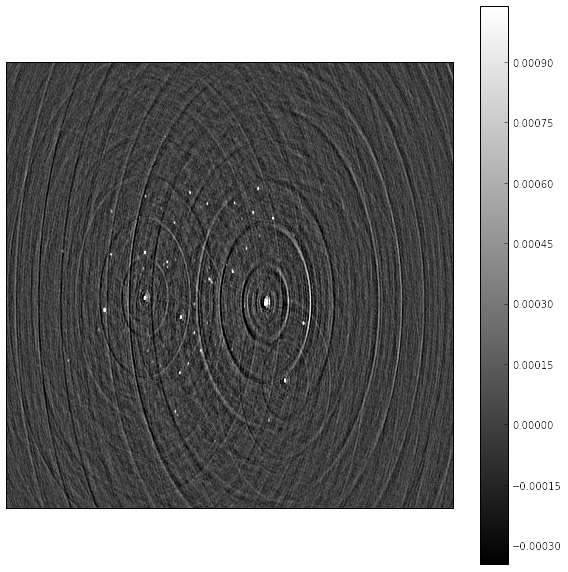

In [11]:
source = cal1 
ccal.source = source
ccal.setup()
lib.qimplot('output/image', rmin=-2, rmax=6)

We will certainly need a few iterations of SelfCal to clean this image up. We do this in the next block:

In [21]:
# scal.invert is attached to the invert task.
# Defaults for the map and beam parameters are set in the next block
# Change parameters as follows:

scal.source = s0
scal.output = 'selfcal_output_1'

scal.invert.robust = -2

scal.selfcal.select = '-uvrange(0,0.5)'
scal.selfcal.options = 'mfs,phase'
scal.selfcal.refant = '2'
scal.selfcal.interval = 2
scal.selfcal.clip = 1e-6

# scal.clean is attached to the clean task 
# Defaults for the map, beam and model fields are set in the next block
# Change parameters as follows:
scal.clean.cutoff = 5e-4
scal.clean.niters=100000

# scal.maths is attached to the MATHS task
# Parameters are shown here for illustration. 
# Change parameters as follows:

# scal.restor is attached to the restor task
# Change parameters as follows:
scal.restor.mode = 'clean'

# scal.imstat is attached to the imstat task

# SelfCal and Image Cycle Settings
# Number of Major Cycles
scal.num_selfcal = 3
# Rename to selfcal_cycle

# Number of minor Cycles
scal.num_clean = 3
# Rename to clean_cycle

# The mask cutoffs will go from immax/cmin...
scal.cmin = 3
# to a minimum of imax/cmax
scal.cmax = 9
# If linear is True, then the mask cutoffs will decrease linearly.
# If linear is False, then the mask cutoffs will be decrease logarithmically, 
# with log10(cmin) and log10(cmax) as the minimum and maximum denominators respectively.
scal.linear = True 
# This is how much deeper than the mask cutoff that we will clean to.
scal.d = 10.
# Cleaning and masking will stop at 7*theoretical rms 
scal.nsigma = 10
# dummy value for the image maximum
scal.immax = 0.0
scal.rmgains = False # Remove gains from vis file.

scal.setup()

# Run Selfcal!
scal.go()

selfcal - WARNING : Cannot find /home/frank/tutorials/tutorial-ugc9519/selfcal_output_1, making it 
selfcal - WARNING : You have now moved into /home/frank/tutorials/tutorial-ugc9519/selfcal_output_1
selfcal - WARNING : All outputs will be relative to this path.
selfcal - INFO : Making symbolic/soft link to your visibility file
basher - DEBUG : ln -s /home/frank/tutorials/tutorial-ugc9519/src.uv_chan0
basher - DEBUG : Returning output.
masher - INFO : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - DEBUG : obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - DEBUG : Command = obsrms jyperk=150 tsys=50 inttime=720.0 bw=20 coreta=0.88 theta=15 freq=1.4 antdiam=25 nants=11 
basher - DEBUG : 
OBSRMS: version 28-SEP-2007
 tsys  jyperk  freq   lambda    deltav     bw  inttime   nants    theta    coreta   rmsphase
   50.   9.4    1.40   214.14  4282.75   20.00  720.00    11.   15.0  

Finally, let's have a look at the output of the SelfCal:

QIMPLOT - INFO : Quick Image Plot
miriad fits - DEBUG : Cleanup - files will be DELETED.
basher - DEBUG : rm -r selfcal_output_1/image.fits
basher - DEBUG : Returning output.
masher - INFO : fits in_=selfcal_output_1/image out=selfcal_output_1/image.fits op=xyout 
basher - DEBUG : fits in_=selfcal_output_1/image out=selfcal_output_1/image.fits op=xyout 
basher - DEBUG : Command = fits in_=selfcal_output_1/image out=selfcal_output_1/image.fits op=xyout 
basher - DEBUG : 

fits: CVS Revision 1.24, 2013/03/14 17:33:00 UTC


basher - DEBUG : Returning output.
miriad fits - INFO : Completed.
QIMPLOT - INFO : RMS = 0.00015
QIMPLOT - INFO : Plotting from -2*RMS to 6*RMS


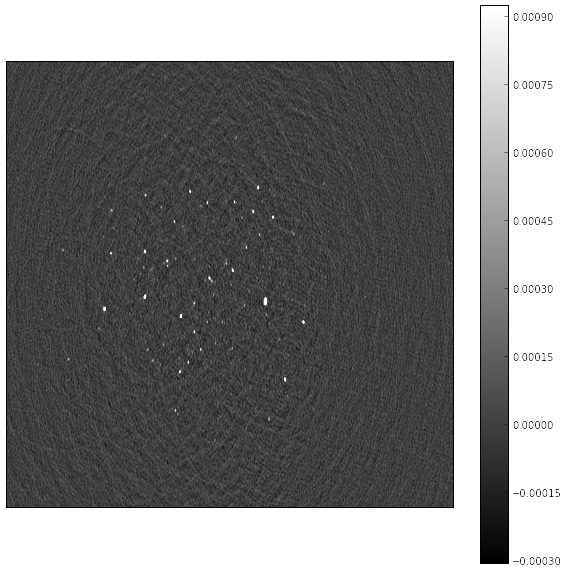

In [8]:
lib.qimplot('selfcal_output_1/image', rmin=-2, rmax=6)